In [207]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import time
import wandb
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
# import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path, PurePath
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
# from warmup_scheduler import GradualWarmupScheduler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 1.0.7
torch version 2.3.1


In [4]:
wandb.login(key=os.getenv('wandb_api_key'))

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Asus\.netrc


True

In [5]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [6]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Config

In [135]:
# TODO: maybe use condition and level for classes
classes = ['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'] + ['H'] # add healthy class

classes = ['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
       'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
       'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
       'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
       'RSSL4L5', 'LSSL5S1', 'RSSL5S1'] + ['H']

num_classes = len(classes)
class2id = {b: i for i, b in enumerate(classes)}

In [178]:
train_dir = Path('E:\data\RSNA2024')

class CFG:

    project = 'rsna-local'
    comment = 'first'

    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 

    image_size = 256
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    PNG_DIR = ROOT_FOLDER / f'pngs_{image_size}'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'

    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = RESULTS_DIR / 'ckpt'

    classes = classes

    split_fraction = 0.95

    MIXUP = False

    ### training
    BATCH_SIZE = 128
    
    ### Optimizer
    N_EPOCHS = 10
    USE_SCHD = False
    WARM_EPOCHS = 3
    COS_EPOCHS = N_EPOCHS - WARM_EPOCHS

    # LEARNING_RATE = 5*1e-5 # best
    LEARNING_RATE = 5e-5
    
    weight_decay = 1e-6 # for adamw

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ### split train and validation sets
    num_workers = 16

    random_seed = 42

CFG.N_LABELS = len(CFG.classes)

seed_torch(seed = CFG.random_seed)

In [150]:
CFG.N_LABELS 

26

### Load data

In [8]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)
coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

train_df.shape, train_desc_df.shape, coords_df.shape, files_df.shape

((1975, 26), (6294, 3), (48692, 16), (147218, 13))

In [9]:
train_df.sample(5)

,study_id,SCSL1L2,SCSL2L3,SCSL3L4,SCSL4L5,SCSL5S1,LNFNL1L2,LNFNL2L3,LNFNL3L4,LNFNL4L5,...,LSSL1L2,LSSL2L3,LSSL3L4,LSSL4L5,LSSL5S1,RSSL1L2,RSSL2L3,RSSL3L4,RSSL4L5,RSSL5S1
1825,3956571539,N,N,N,N,N,N,N,N,M,...,N,N,N,M,N,N,N,N,N,M
1735,3768387090,N,N,N,M,N,N,N,N,N,...,N,N,N,S,N,N,N,N,N,N
678,1504031267,N,N,N,N,N,N,N,M,M,...,N,M,M,N,N,N,N,N,N,N
351,783154228,N,M,S,N,N,M,S,M,S,...,N,M,M,N,N,N,M,M,M,M
1791,3884015124,M,N,M,N,N,N,N,N,M,...,M,N,N,S,S,M,N,M,M,M


In [10]:
coords_df.shape

(48692, 16)

In [11]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,plane,rows,columns,filename,x_perc,y_perc
9389,838134337,1345841225,8,RNFN,L1L2,299.627093,141.857522,838134337_1345841225,838134337_1345841225_8,RNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\838134337_1345841225...,0.585209,0.277065
34671,3068697362,598012396,5,LNFN,L5S1,132.562118,195.910387,3068697362_598012396,3068697362_598012396_5,LNFNL5S1,Sagittal T1,256,256,E:\data\RSNA2024\pngs_256\3068697362_598012396...,0.517821,0.765275


In [12]:
coords_df.condition.unique()

array(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'], dtype=object)

In [13]:
coords_df.cl.unique()

array(['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
       'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
       'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
       'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
       'RSSL4L5', 'LSSL5S1', 'RSSL5S1'], dtype=object)

In [14]:
# coords_df.groupby(['study_id','series_id']).instance.count()

In [15]:
train_desc_df.sample(5)

,study_id,series_id,series_description
3465,2403128572,1121608562,Sagittal T2/STIR
2413,1671291853,1440089134,Axial T2
5109,3480977444,2937779262,Axial T2
3727,2568819355,3366910731,Axial T2
5996,4095029738,3276164246,Sagittal T2/STIR


In [16]:
files_df.sample(3)

,study_id,series_id,image,instancenumber,rows,columns,slicethickness,spacingbetweenslices,patientposition,seriesdescription,ss_id,instance_id,filename
14665,1383495058,2595899035,42,42,640,640,3.5,3.85,HFS,T2,1383495058_2595899035,1383495058_2595899035_42,E:\data\RSNA2024\pngs_256\1383495058_259589903...
13125,1336412861,1402829528,17,17,448,448,3.0,3.60,HFS,T1,1336412861_1402829528,1336412861_1402829528_17,E:\data\RSNA2024\pngs_256\1336412861_140282952...
26491,1716586508,3464148753,8,8,360,384,4.0,4.92,HFS,NaN,1716586508_3464148753,1716586508_3464148753_8,E:\data\RSNA2024\pngs_256\1716586508_346414875...


In [17]:
files_df.shape

(147218, 13)

In [18]:
# labels, potive imgs, total imgs
coords_df.instance_id.nunique(), coords_df.ss_id.nunique(), files_df.shape[0]

(24546, 6291, 147218)

In [19]:
coords_df.sample(3)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,plane,rows,columns,filename,x_perc,y_perc
34000,3010856283,3908286977,9,SCS,L3L4,167.832287,148.588357,3010856283_3908286977,3010856283_3908286977_9,SCSL3L4,Sagittal T2/STIR,320,320,E:\data\RSNA2024\pngs_256\3010856283_390828697...,0.524476,0.464339
35159,3127048494,4135498856,10,LSS,L3L4,274.673837,262.827798,3127048494_4135498856,3127048494_4135498856_10,LSSL3L4,Axial T2,512,512,E:\data\RSNA2024\pngs_256\3127048494_413549885...,0.536472,0.513336
35173,3128795155,483456514,6,RNFN,L3L4,224.246055,234.605452,3128795155_483456514,3128795155_483456514_6,RNFNL3L4,Sagittal T1,448,448,E:\data\RSNA2024\pngs_256\3128795155_483456514...,0.500549,0.523673


In [20]:
files_df.shape, coords_df.shape

((147218, 13), (48692, 16))

In [21]:
coords_df.instance_id.nunique(), coords_df.filename.nunique()

(24546, 24546)

In [22]:
# conditions per file
grp = coords_df.groupby('instance_id').condition
grp.count().min(), grp.count().max(), grp.count().mean()

(1, 10, 1.983704065835574)

In [41]:
inst_id = '2509953825_3594374345_13'

coords_df[coords_df['instance_id'] == inst_id]

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,plane,rows,columns,filename,x_perc,y_perc
28080,2509953825,3594374345,13,LNFN,L1L2,261.574913,169.923345,2509953825_3594374345,2509953825_3594374345_13,LNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,0.510889,0.331882
28081,2509953825,3594374345,13,LNFN,L2L3,255.331010,211.846690,2509953825_3594374345,2509953825_3594374345_13,LNFNL2L3,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,0.498693,0.413763
28082,2509953825,3594374345,13,LNFN,L3L4,252.655052,252.878049,2509953825_3594374345,2509953825_3594374345_13,LNFNL3L4,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,0.493467,0.493902
28083,2509953825,3594374345,13,LNFN,L4L5,258.006969,294.801394,2509953825_3594374345,2509953825_3594374345_13,LNFNL4L5,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,0.503920,0.575784
28084,2509953825,3594374345,13,LNFN,L5S1,279.414634,333.156794,2509953825_3594374345,2509953825_3594374345_13,LNFNL5S1,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,0.545732,0.650697


In [42]:
coords_df[coords_df['instance_id'] == inst_id].cl.to_list()

['LNFNL1L2', 'LNFNL2L3', 'LNFNL3L4', 'LNFNL4L5', 'LNFNL5S1']

In [36]:
# list(coords_df.filename.unique())

### Dataset

In [138]:
from dataset import rsna_dataset

In [139]:
dset = rsna_dataset(coords_df, CFG)

print(dset.__len__())

img, label, = dset.__getitem__(2)
print(img.shape, label.shape)
print(img.dtype, label.dtype)

24546
(3, 256, 256) torch.Size([26])
float32 torch.float32


In [140]:
label

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
img.mean(), img.std(), img.min(), img.max()

(28.952377, 43.967163, 0.0, 249.0)

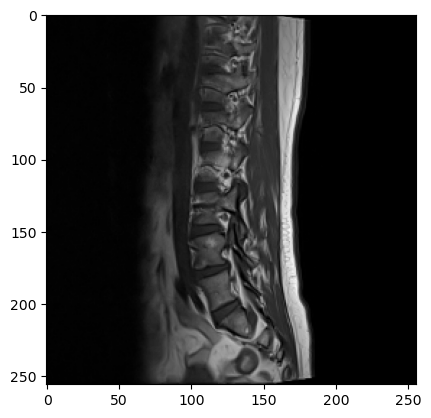

In [142]:
plt.imshow(img[0], cmap='gray')

### Datamodule

In [143]:
from dataset import rsna_dataset

In [144]:
class rsna_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, cfg=CFG, train_tfs=None, val_tfs=None):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        # self.coord_df = coord_df
        
        self.train_bs = cfg.BATCH_SIZE
        self.val_bs = cfg.BATCH_SIZE

        self.train_tfs = train_tfs
        self.val_tfs = val_tfs

        self.cfg = cfg
        
        self.num_workers = cfg.num_workers
        
    def train_dataloader(self):
        train_ds = rsna_dataset(self.train_df, self.cfg, tfs=self.train_tfs, mode='train')
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = rsna_dataset(self.val_df, self.cfg, tfs=self.val_tfs, mode='val')
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=2,
        )
        
        return val_loader

In [145]:
t_df = coords_df[:-100]
# t_df = pd.concat([meta_df[:-100], ul_df[:-100]], ignore_index=True)
v_df = coords_df[-100:]

CFG2 = CFG
CFG2.BATCH_SIZE = 16
CFG2.num_workers = 2

dm = rsna_datamodule(t_df, v_df, cfg=CFG2)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 26]),
 torch.float32,
 torch.float32)

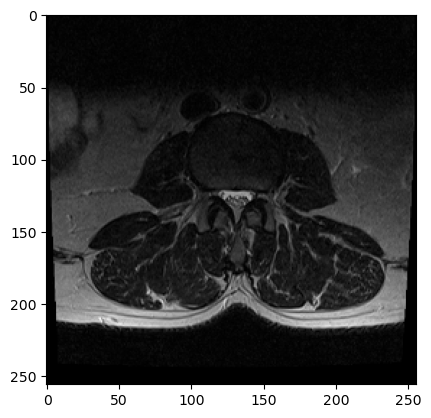

In [146]:
plt.imshow(x[10][0], cmap='gray')

#### Check Transforms

In [147]:
image_size = CFG.image_size

img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

train_tfs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    A.CoarseDropout(max_height=int(image_size * 0.2), max_width=int(image_size * 0.2), max_holes=4, p=0.7),
    A.Normalize(mean=img_mean, std=img_std)
])

val_tfs = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=img_mean, std=img_std)
])

In [122]:
dm = rsna_datamodule(t_df, v_df, cfg=CFG2, train_tfs=train_tfs, val_tfs=val_tfs)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 26]),
 torch.float32,
 torch.float32)

In [123]:
y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

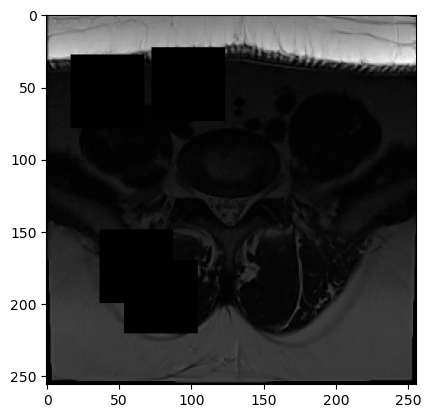

In [124]:
plt.imshow(x[2][0], cmap='gray')

In [125]:
del dm

### Loss function

In [126]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [127]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Model

In [128]:
backbone = 'eca_nfnet_l1'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=dset.num_classes,
    # out_indices=out_indices,
    )

model.feature_info.channels(), np.sum(model.feature_info.channels())

([64, 256, 512, 1536, 3072], 5440)

In [129]:
data_config = timm.data.resolve_model_data_config(model)

In [130]:
data_config

{'input_size': (3, 256, 256),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [132]:
def mixup(data, targets, alpha, device):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)]).to(device)
    data = data * lam + data2 * (1 - lam)
    
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

    # data += data2
    # targets += targets2
    # return data, targets.clip(max=1)

In [154]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg
        
        out_indices = (3, 4)

        self.criterion = FocalLossBCE()

        self.train_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)
        self.val_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)

        # self.train_acc = tm.classification.MultilabelAccuracy(num_labels=self.cfg.N_LABELS)
        self.val_macc = tm.classification.MultilabelAccuracy(num_labels=self.cfg.N_LABELS)

        self.train_auroc = tm.classification.MulticlassAUROC(num_classes=self.cfg.N_LABELS)
        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, self.cfg.N_LABELS)

    def forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LEARNING_RATE, weight_decay=CFG.weight_decay)
        
        if self.cfg.USE_SCHD:
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.cfg.COS_EPOCHS)
            scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=self.cfg.WARM_EPOCHS, after_scheduler=scheduler_cosine)

            return [optimizer], [scheduler_warmup]
        else:
            # LRscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
            
            # return [optimizer], [LRscheduler]
            return optimizer

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch

        if self.cfg.MIXUP and mode == 'train':
            x, y = mixup(x, y, 0.5, self.cfg.device)
        
        preds = self(x)
        
        loss = self.criterion(preds, y)
        
        if mode == 'train':
            self.train_acc(preds, y.argmax(1))
        else:
            self.val_acc(preds, y.argmax(1))
            self.val_macc(preds, y)
        
        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        self.log(f'train/acc', self.train_acc, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='val')
        self.log(f'val/acc', self.val_acc, on_step=True, on_epoch=True)
        self.log(f'val/macc', self.val_macc, on_step=True, on_epoch=True)
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.val_acc.reset()
        self.val_macc.reset()

In [155]:
model = GeMModel(CFG)

eca_nfnet_l0


In [156]:
foo = model(x)

In [158]:
x.shape, foo.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 26]))

### Split

In [159]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [211]:
# add healthy images

files_df.shape, files_df.filename.nunique(), coords_df.filename.nunique()

((147218, 13), 147218, 24546)

In [161]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-CFG.split_fraction, random_state=CFG.random_seed)
train_idx, val_idx = next(sss.split(coords_df.filename, coords_df.cl))

t_df = coords_df.iloc[train_idx]
v_df = coords_df.iloc[val_idx]

t_df.shape, v_df.shape

((46257, 16), (2435, 16))

### Train

In [164]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [168]:
CFG.BATCH_SIZE, CFG.device

(128, 'cuda')

In [166]:
dm = rsna_datamodule(t_df, v_df, cfg=CFG2, train_tfs=train_tfs, val_tfs=val_tfs)
len(dm.train_dataloader()), len(dm.val_dataloader())

(1498, 146)

In [167]:
run_name = f'{CFG.model_name} {CFG.LEARNING_RATE} {CFG.N_EPOCHS} eps {CFG.comment}'
run_name

'eca_nfnet_l0 5e-05 30 eps first'

In [171]:
wandb_logger = WandbLogger(
    name=run_name,
    project=CFG.project,
    job_type='train',
    save_dir=CFG.RESULTS_DIR,
    # config=cfg,
)

loss_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/loss',
    auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    filename='ep_{epoch:02d}_loss_{val/loss:.5f}',
    save_top_k=2,
    mode='min',
)

acc_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/acc',
    auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    filename='ep_{epoch:02d}_acc_{val/acc:.5f}',
    save_top_k=2,
    mode='max',
)

lr_monitor = LearningRateMonitor(logging_interval='step')

In [172]:
trainer = pl.Trainer(
    max_epochs=CFG.N_EPOCHS,
    deterministic=True,
    accelerator=CFG.device,
    default_root_dir=CFG.RESULTS_DIR,
    gradient_clip_val=0.5, 
    # gradient_clip_algorithm="value",
    logger=wandb_logger,
    callbacks=[loss_ckpt, acc_ckpt, lr_monitor],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [179]:
model = GeMModel(CFG)

eca_nfnet_l0


In [180]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | criterion    | FocalLossBCE       | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | val_macc     | MultilabelAccuracy | 0      | train
4 | train_auroc  | MulticlassAUROC    | 0      | train
5 | backbone     | FeatureListNet     | 21.8 M | train
6 | global_pools | ModuleList         | 2      | train
7 | neck         | BatchNorm1d        | 7.7 K  | train
8 | head         | Linear             | 99.9 K | train
------------------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.786    Total estimated model params size (MB)


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |                                                                               | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
wandb.finish()

### Predict

In [182]:
x, y = next(iter(dm.train_dataloader()))

In [184]:
# foo = model(x)
foo = model(x.to(CFG.device))
foo.shape

torch.Size([16, 26])

In [205]:
torch.where(y[0] > 0)

(tensor([15, 16]),)

In [204]:
bar = foo[0].sigmoid().detach().cpu().numpy()
np.argwhere(bar > 0.5)

array([[15],
       [16]], dtype=int64)

In [196]:
torch.nn.functional.sigmoid(foo[0])

tensor([6.4998e-03, 5.0024e-03, 5.9809e-03, 6.4397e-03, 4.3466e-03, 3.9961e-03,
        1.9555e-03, 3.6611e-03, 2.0490e-03, 7.1997e-03, 6.9344e-03, 3.3937e-03,
        2.2832e-03, 6.5359e-03, 2.8564e-03, 6.5635e-01, 9.7104e-01, 1.5922e-03,
        1.9428e-03, 6.1714e-03, 2.5854e-03, 2.1531e-03, 1.6715e-03, 3.0678e-03,
        2.8539e-03, 2.0925e-04], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [197]:
# foo.sigmoid().topk(1, dim=-1)